In [6]:
# Importing necessary packages

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score,plot_confusion_matrix,accuracy_score,mean_absolute_error,roc_curve,plot_roc_curve,roc_auc_score,mean_absolute_percentage_error,r2_score,mean_squared_error,recall_score,precision_score,classification_report

In [2]:
# Loading the data and merging it on identical columns

d1=pd.read_csv('Loan_Details_transactions.csv')
# d1.head()
d2=pd.read_csv('Loan_status_mapping.csv')
# d2.head()
d3=pd.merge(d1,d2,on='Loan_Id')
# d3.head()
Branch_ID=pd.read_csv('Branch_ID_Master.csv')
# Branch_ID.head()
d4=pd.merge(d3,Branch_ID,on='Branch_Id',how='left')
# d4.head()
State_Master=pd.read_excel('State_Master.xlsx')
# State_Master.head()
d5=pd.merge(d4,State_Master,on='State_Code',how='left')
# d5.head()
City_Master=pd.read_excel('City_Master.xlsx')
# City_Master.head()
d6=pd.merge(d5,City_Master,on=['State_Code','City_Code'],how='left')
# d6.head()
State_Region_Mapping=pd.read_excel('State_Region_Mapping.xlsx')
# State_Region_Mapping.head()
State_Region_Mapping.rename(columns={'State Name':'State_Name','Region':'Region_Name'},inplace=True)
d7=pd.merge(d6,State_Region_Mapping,on=['State_Code','State_Name'],how='left')
# d7.head()

In [3]:
# Imputing null values based on state geography

for i in range(len(d7)):
    if (d7.loc[i,'State_Name']=='Uttarakhand') | (d7.loc[i,'State_Name']=='Uttar Pradesh') :
        d7.loc[i,'Region_ID']='R1' 
    elif (d7.loc[i,'State_Name']=='Madhya Pradesh') :
        d7.loc[i,'Region_ID']='R4'
    elif (d7.loc[i,'State_Name']=='Sikkim') :
        d7.loc[i,'Region_ID']='R3'

In [4]:
# Dropping redundant data

d7.drop(columns='Region_Name',inplace=True)
Region_Master=pd.read_excel('Region_Master.xlsx')
# Region_Master.head()
d8=pd.merge(d7,Region_Master,on='Region_ID',how='left')
# d8.head()
data=d8.drop(columns=['City_Code','State_Code','Region_ID','Postal_Code','Region_Code'])
#data.info()

In [5]:
# Data cleaning

data['Date_of_Birth']=pd.to_datetime(data['Date_of_Birth'])
data['DisbursalDate']=pd.to_datetime(data['DisbursalDate'])
data['Age'] = data['Date_of_Birth'].apply(lambda x : (pd.datetime.now().year - x.year))
data['Years_from_Disbursal'] = data['DisbursalDate'].apply(lambda x : (pd.datetime.now().year - x.year))
data['Credit_Hist_Length_in_Months'] = data['CREDIT.HISTORY.LENGTH'].apply(lambda x : (int(''.join((list(x.split()[0])[0:-3])))*12)+(int(''.join((list(x.split()[1])[0:-3])))))
data.drop(columns=['Date_of_Birth','DisbursalDate','CREDIT.HISTORY.LENGTH'],inplace=True)
data.set_index('Loan_Id',inplace=True)
data['Employment_Type'].fillna('Unemployed',inplace=True)
data.head()

,Disbursed_Amount,Asset_Cost,ltv,Branch_Id,Employment_Type,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,State_Name,City_Name,Region_Name,Age,Years_from_Disbursal,Credit_Hist_Length_in_Months
Loan_Id,,,,,,,,,,,,,,,,,,,,,
1,36439,65850,56.19,64,Self employed,1,1,0,0,0,...,0,0,0,0,Maharashtra,Mumbai,West,32,4,0
2,48749,69303,72.15,67,Salaried,1,1,0,0,0,...,783,0,0,0,Tamil Nadu,Chennai,South,31,4,30
3,55348,66340,85.00,2,Self employed,1,1,0,0,0,...,0,0,0,1,Bihar,Patna,East,29,4,0
4,48849,64133,77.96,217,Self employed,1,1,0,0,0,...,0,0,0,0,Rajasthan,Jaipur,North,33,4,0
5,40394,59386,70.72,74,Self employed,1,1,0,0,0,...,14,1,1,0,Tamil Nadu,Chennai,South,48,4,37


In [6]:
# Categorical feature replacing

col2=['MobileNo_Avl_Flag','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag']
for i in col2:
    data[i]=data[i].replace({0:'No',1:'Yes'})

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Disbursed_Amount,23315.0,54297.647309,13061.877434,13369.00,46949.00,53759.00,60379.00,592460.00
Asset_Cost,23315.0,75842.182887,18988.525635,37230.00,65629.00,70929.00,79354.50,715186.00
ltv,23315.0,74.701607,11.462722,17.13,68.83,76.71,83.63,94.98
Branch_Id,23315.0,72.079262,69.095008,1.00,13.00,61.00,121.00,261.00
PERFORM_CNS.SCORE,23315.0,291.234956,338.490214,0.00,0.00,0.00,679.00,890.00
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,23315.0,0.100622,0.388782,0.00,0.00,0.00,0.00,7.00
NO.OF_INQUIRIES,23315.0,0.205790,0.699901,0.00,0.00,0.00,0.00,23.00
Loan_Default,23315.0,0.219858,0.414159,0.00,0.00,0.00,0.00,1.00
Age,23315.0,38.051383,9.788118,22.00,30.00,36.00,45.00,68.00
Years_from_Disbursal,23315.0,4.000000,0.000000,4.00,4.00,4.00,4.00,4.00


In [8]:
data.describe(include='object').T

,count,unique,top,freq
Employment_Type,23315,3,Self employed,12724
MobileNo_Avl_Flag,23315,1,Yes,23315
Aadhar_flag,23315,2,Yes,19703
PAN_flag,23315,2,No,21554
VoterID_flag,23315,2,No,20026
Driving_flag,23315,2,No,22775
Passport_flag,23315,2,No,23267
State_Name,23315,18,Karnataka,2492
City_Name,23315,29,Vadodara,873
Region_Name,23315,4,South,8015


## Comments:
1. 'Years from disbursal' and 'MobileNo_Avl_Flag' has same value in each index. So its useless data.
2. Similarly 'Aadhar_flag','PAN_flag','Driving_flag','Passport_flag' also.

In [9]:
# Dropping unwanted column after analyzing

data=data.drop(columns=['MobileNo_Avl_Flag','Passport_flag','Years_from_Disbursal'])
data.head()

,Disbursed_Amount,Asset_Cost,ltv,Branch_Id,Employment_Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,State_Name,City_Name,Region_Name,Age,Credit_Hist_Length_in_Months
Loan_Id,,,,,,,,,,,,,,,,,,
1,36439,65850,56.19,64,Self employed,Yes,No,No,No,0,0,0,0,Maharashtra,Mumbai,West,32,0
2,48749,69303,72.15,67,Salaried,Yes,No,No,No,783,0,0,0,Tamil Nadu,Chennai,South,31,30
3,55348,66340,85.00,2,Self employed,Yes,No,No,No,0,0,0,1,Bihar,Patna,East,29,0
4,48849,64133,77.96,217,Self employed,Yes,No,No,No,0,0,0,0,Rajasthan,Jaipur,North,33,0
5,40394,59386,70.72,74,Self employed,Yes,No,No,No,14,1,1,0,Tamil Nadu,Chennai,South,48,37


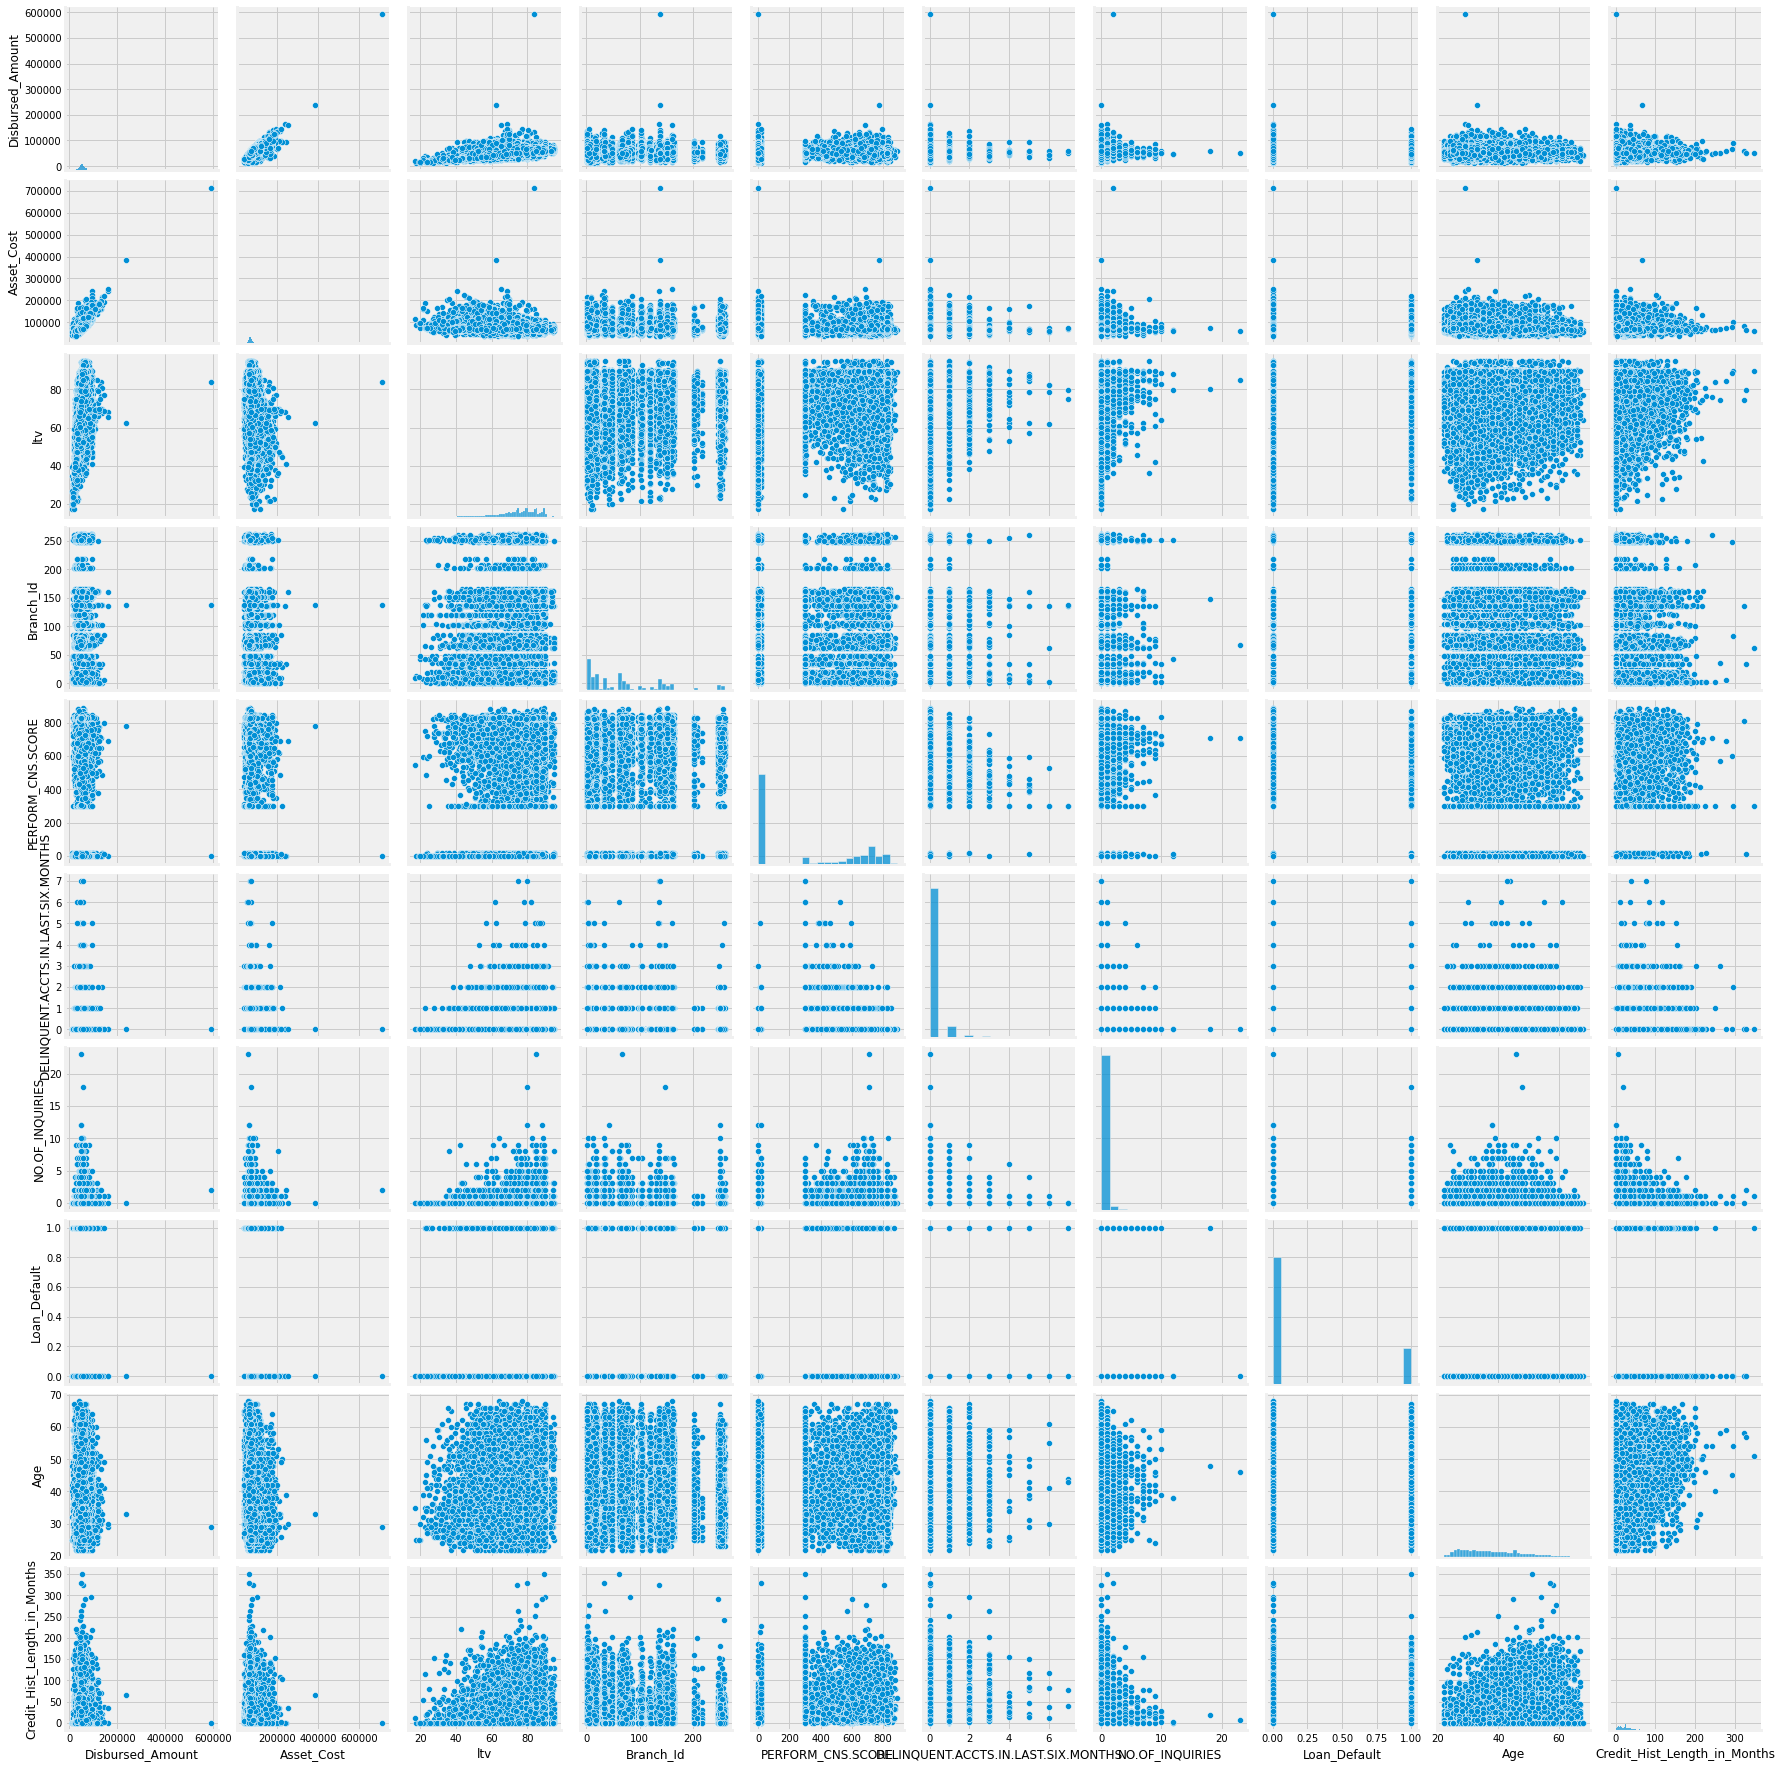

In [10]:
sns.pairplot(data)

In [11]:
# Clean Data Storing

data.to_csv('cleaned_data.csv')

In [12]:
data.columns

Index(['Disbursed_Amount', 'Asset_Cost', 'ltv', 'Branch_Id', 'Employment_Type',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'PERFORM_CNS.SCORE', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Loan_Default', 'State_Name', 'City_Name',
       'Region_Name', 'Age', 'Credit_Hist_Length_in_Months'],
      dtype='object')

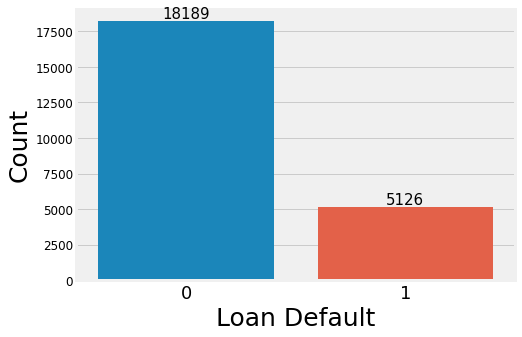

In [13]:
# Checking Target variable

plt.figure(figsize=(7,5))
ax=sns.countplot(x='Loan_Default',data=data)
ax.bar_label(ax.containers[0],fontsize=15)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
plt.xticks(fontsize=18)
ax.set_xlabel('Loan Default',fontsize=25)
ax.set_ylabel('Count',fontsize=25)
plt.show()

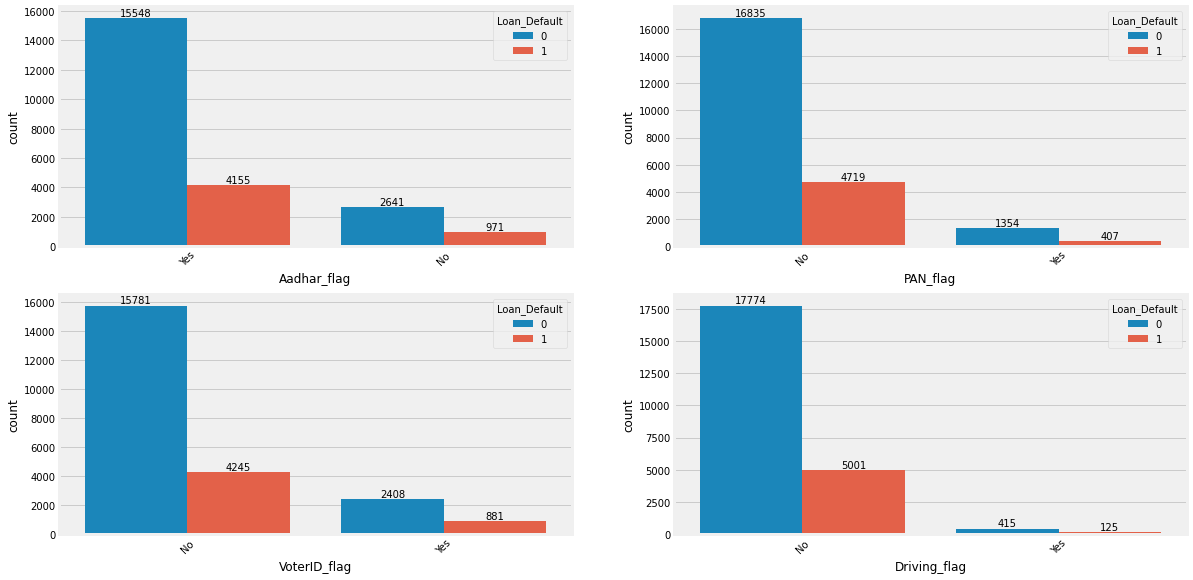

In [14]:
# EDA on categorical features

col=['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag']
plt.figure(figsize=(18,15),facecolor='white')
plot_num=1
for i in col:
    ax=plt.subplot(3,2,plot_num)
    ax=sns.countplot(x=i,data=data,hue='Loan_Default')
    ax.bar_label(ax.containers[0],fontsize=10)
    ax.bar_label(ax.containers[1],fontsize=10)
    plt.xticks(rotation=45)
    plot_num+=1
plt.show()

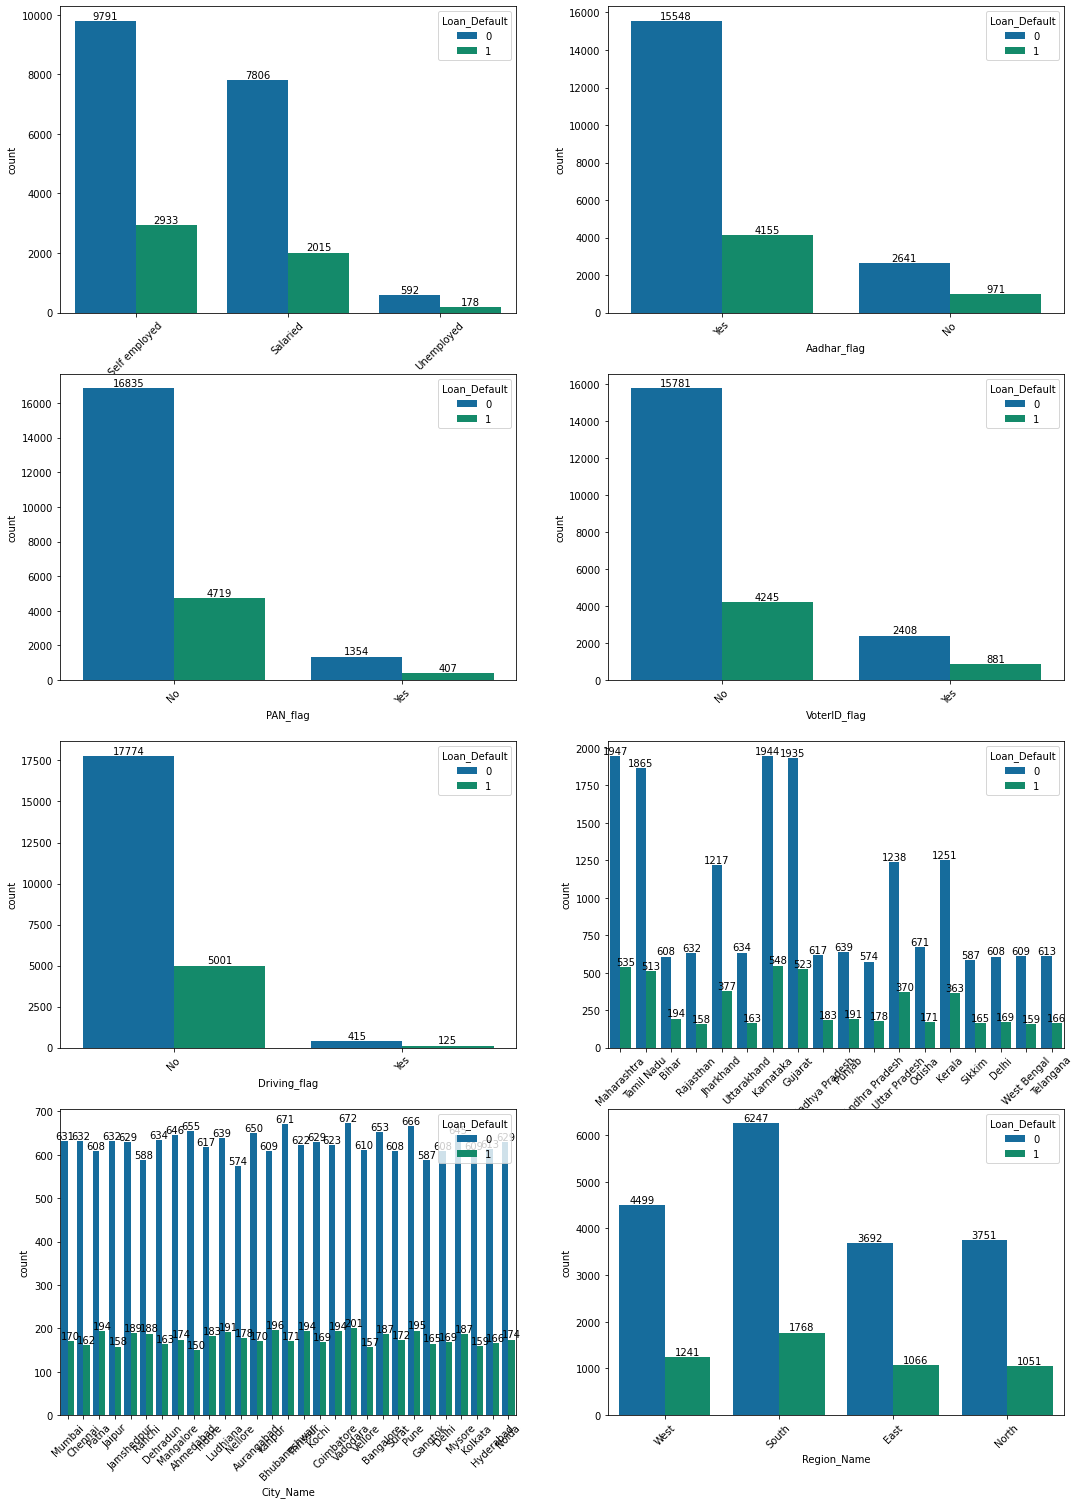

In [10]:
# Plotting countplot of categorical variable to visualize distribution.

plt.figure(figsize=(18,80),facecolor='white')
plot_num=1
for i in data.select_dtypes('object').columns:
    ax=plt.subplot(12,2,plot_num)
    ax=sns.countplot(x=i,data=data,hue='Loan_Default')
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.xticks(rotation=45)
    plot_num+=1
plt.show()

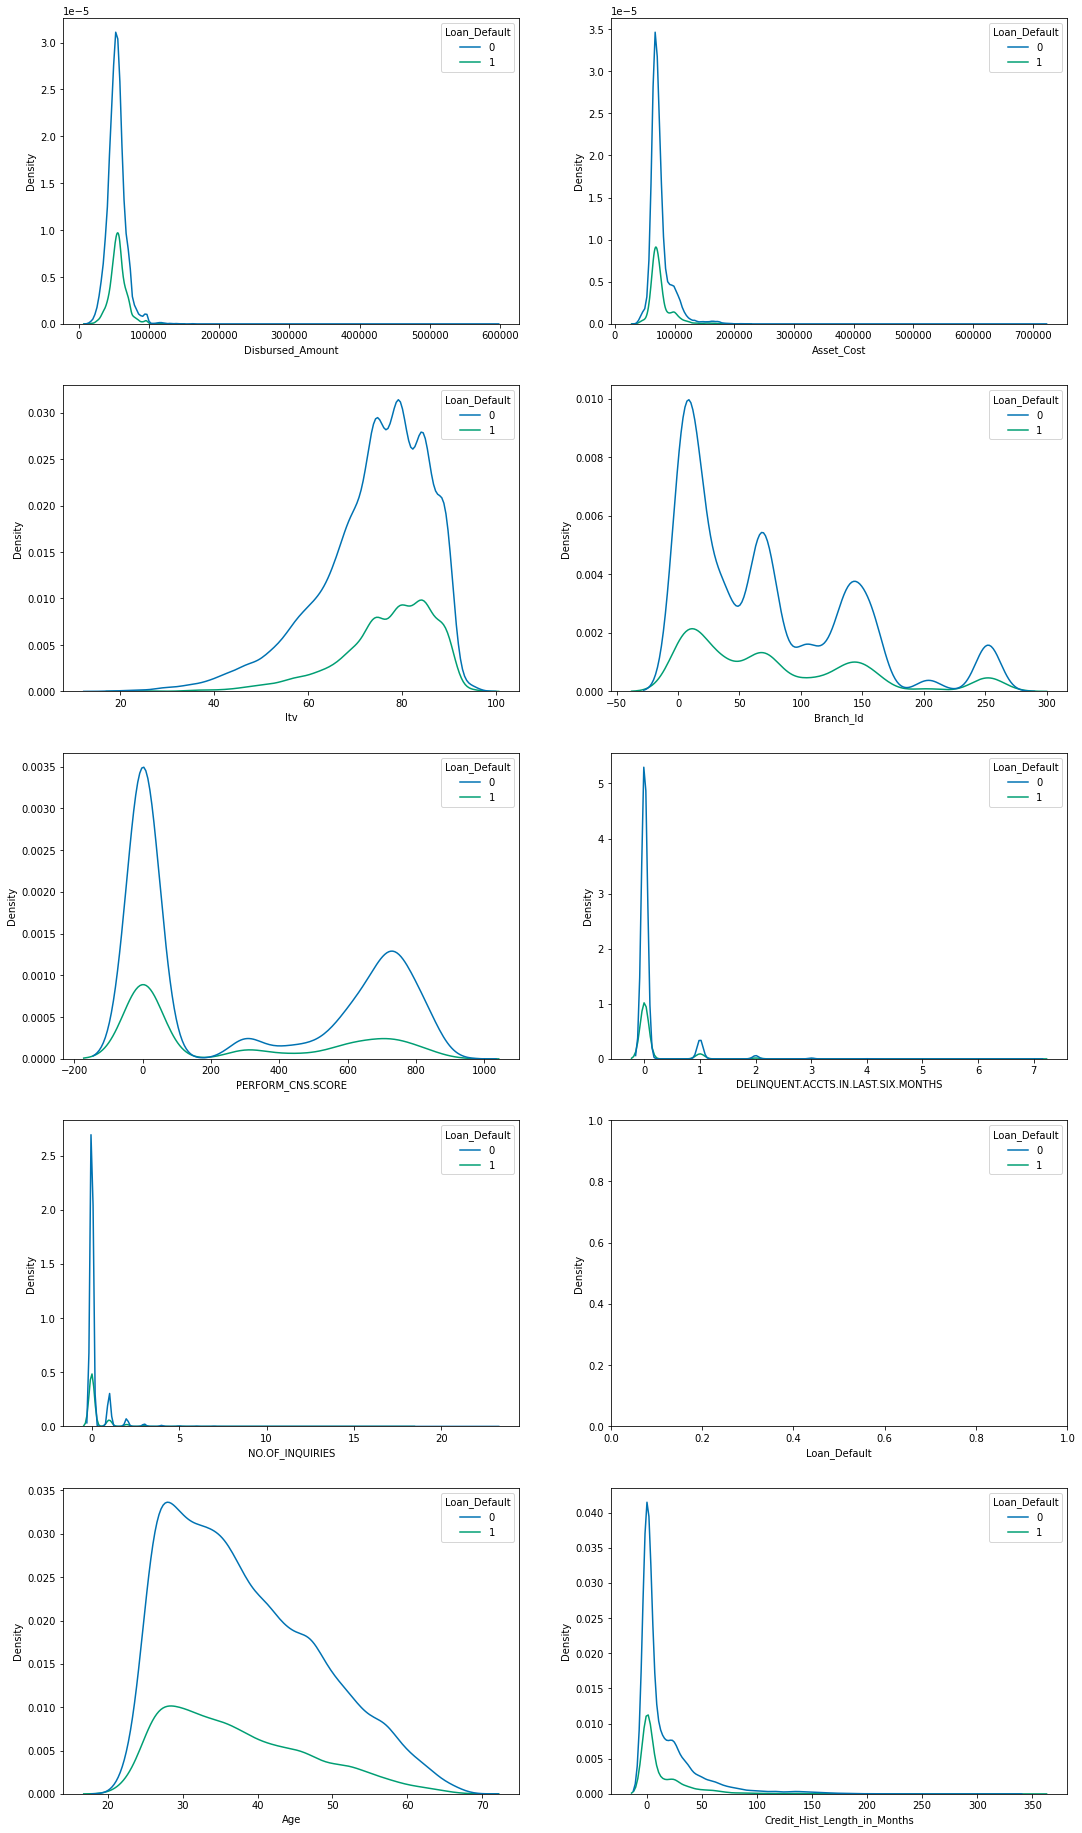

In [23]:
# Plotting distplot to visualize distribution of numerical features

plt.figure(figsize=(18,80),facecolor='white')
plot_num=1
for i in data.select_dtypes(exclude='object').columns:
    ax=plt.subplot(12,2,plot_num)
    sns.kdeplot(x=i,data=data,hue='Loan_Default')
    plot_num+=1
plt.show()

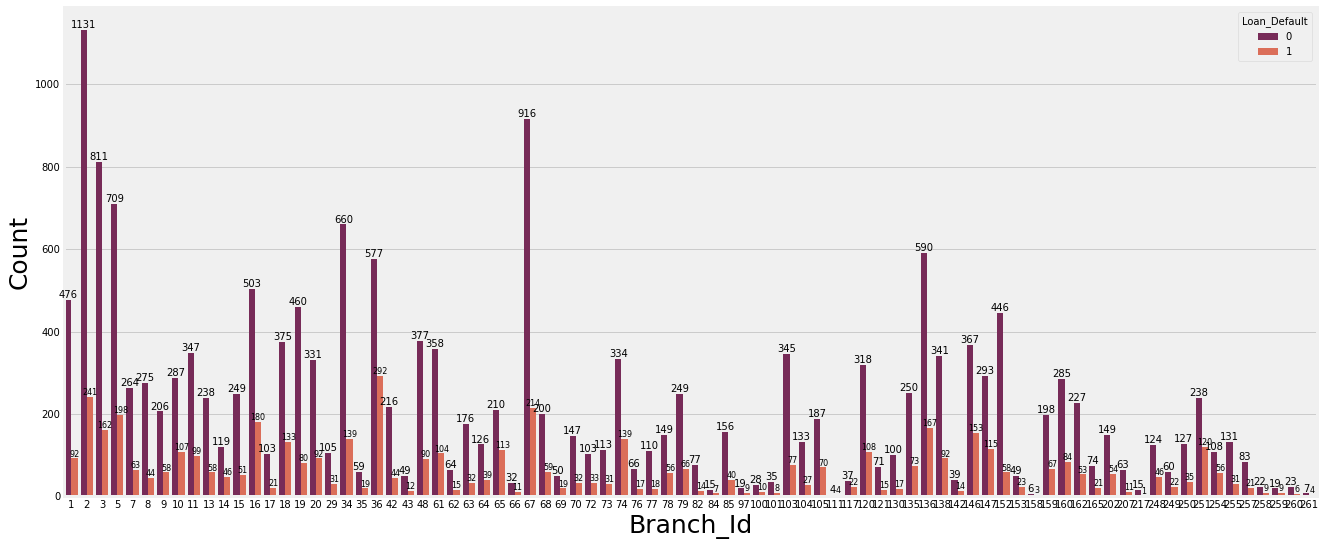

In [15]:
# Checking Branch Id

plt.figure(figsize=(20,9))
ax=sns.countplot(x='Branch_Id',data=data,hue='Loan_Default',palette='rocket',orient='h')
ax.bar_label(ax.containers[0],fontsize=10)
ax.bar_label(ax.containers[1],fontsize=8)
ax.set_xlabel('Branch_Id',fontsize=25)
ax.set_ylabel('Count',fontsize=25)
plt.show()

## Comments:
1. Branch Id 36 is having highest number of defaulters.
2. Most loans passed by Branch Id 2 and 67.

In [16]:
data.drop(columns=['City_Name','Branch_Id'],inplace=True)

In [17]:
data.isnull().sum()

Disbursed_Amount                       0
Asset_Cost                             0
ltv                                    0
Employment_Type                        0
Aadhar_flag                            0
PAN_flag                               0
VoterID_flag                           0
Driving_flag                           0
PERFORM_CNS.SCORE                      0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0
NO.OF_INQUIRIES                        0
Loan_Default                           0
State_Name                             0
Region_Name                            0
Age                                    0
Credit_Hist_Length_in_Months           0
dtype: int64

In [18]:
df=data.copy()
data_out=data.copy()

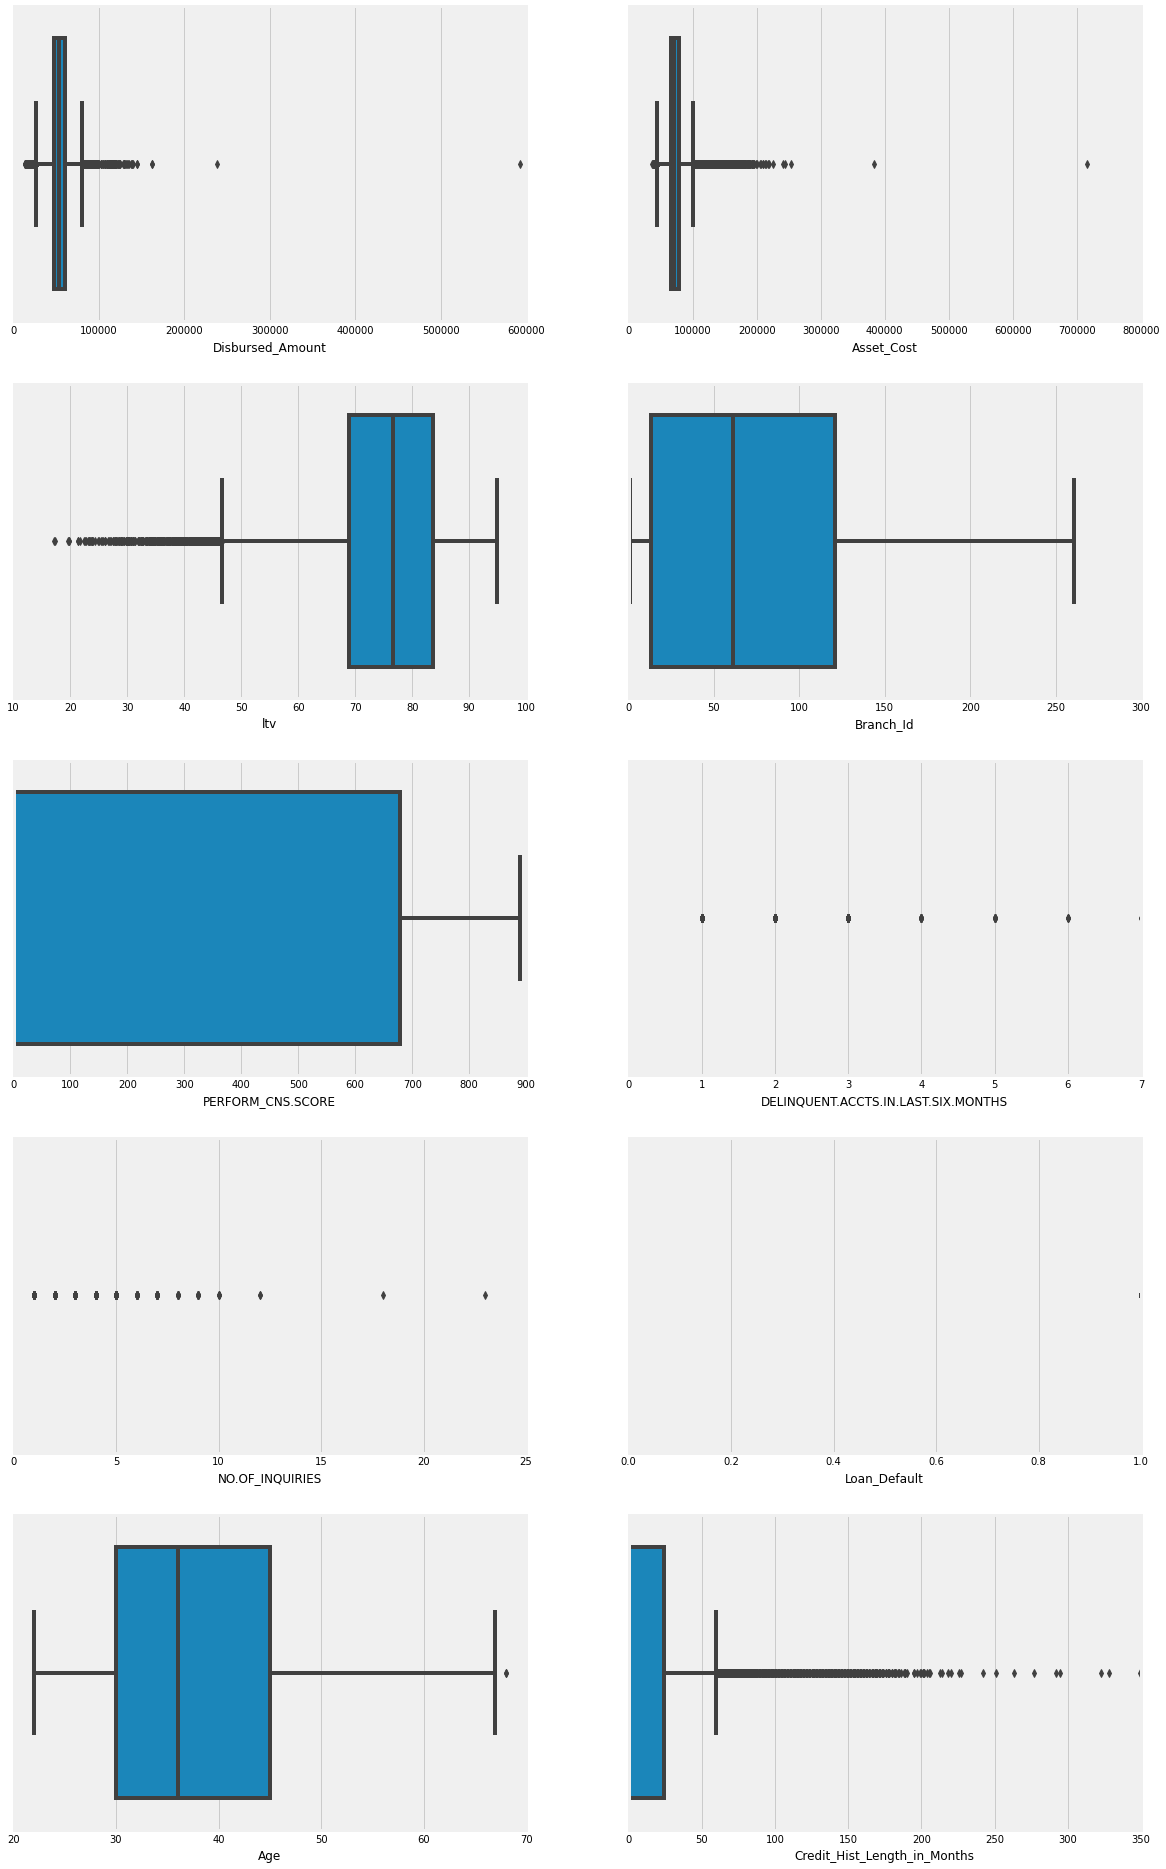

In [148]:
# Plotting boxplot to identify outliers.

plt.figure(figsize=(18,80),facecolor='white')
plot_num=1
for i in data.select_dtypes(exclude='object').columns:
    ax=plt.subplot(12,2,plot_num)
    sns.boxplot(data[i])
    plt.xlabel(i)
    plot_num+=1
plt.show()

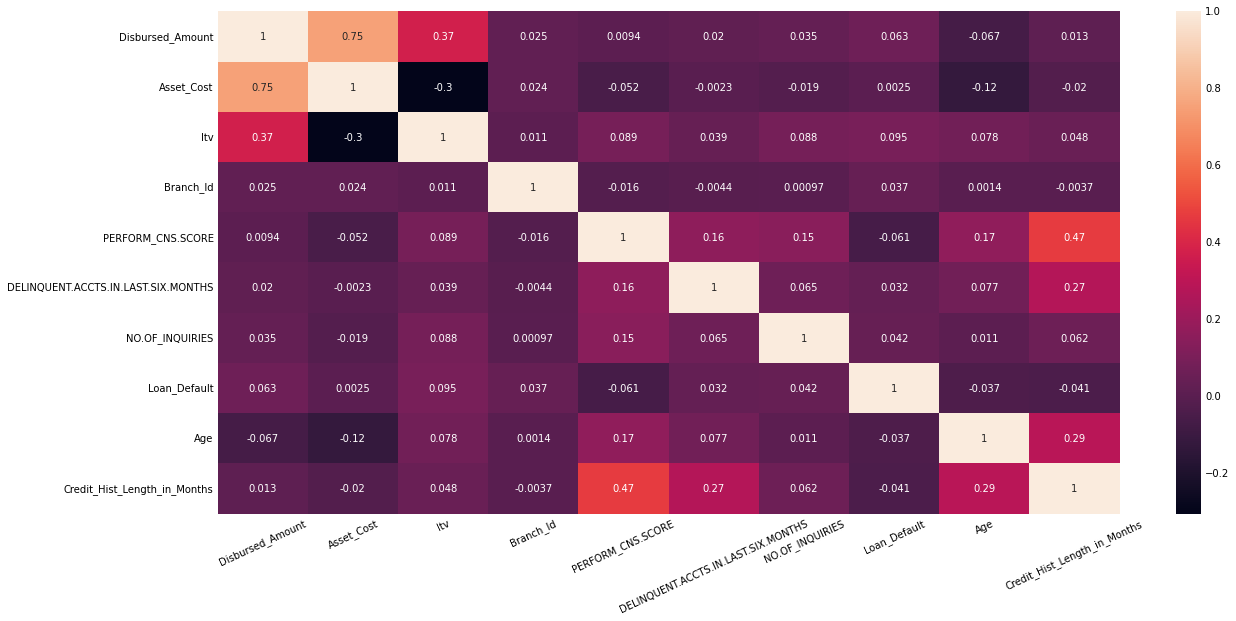

In [151]:
# Plotting heatmap to see the intensity of relation.

plt.figure(figsize=(18,9))
sns.heatmap(data.corr(),annot=True)
plt.xticks(rotation=25)
plt.show()

## Data for models:
#### which are not sensitive to outliers.

    A. DecisionTree Classifier
    B. Ensemble Techniques
        1. RandomForest Classifier
        2. AdaBoost Classifier 
        3. GradientBoost Classifier
        4. XGB Classifier

In [15]:
df.head()

,Disbursed_Amount,Asset_Cost,ltv,Employment_Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,State_Name,Region_Name,Age,Credit_Hist_Length_in_Months
Loan_Id,,,,,,,,,,,,,,,,
1,36439,65850,56.19,Self employed,Yes,No,No,No,0,0,0,0,Maharashtra,West,32,0
2,48749,69303,72.15,Salaried,Yes,No,No,No,783,0,0,0,Tamil Nadu,South,31,30
3,55348,66340,85.00,Self employed,Yes,No,No,No,0,0,0,1,Bihar,East,29,0
4,48849,64133,77.96,Self employed,Yes,No,No,No,0,0,0,0,Rajasthan,North,33,0
5,40394,59386,70.72,Self employed,Yes,No,No,No,14,1,1,0,Tamil Nadu,South,48,37


In [19]:
dummy=df.copy()

In [59]:
# Creating function for decision making about which transformation is suitable.
def transformation(df,val):
    df[val+'_sqroot']=np.sqrt(df[val])
    df[val+'_square']=(df[val])**2
    df[val+'_log']=np.log(df[val])
    df[val+'_cuberoot']=np.cbrt(df[val])
    plt.figure(figsize=(18,10))
    plt.subplot(2,3,1)
    df[val].plot(kind='hist')
    plt.title('Original')
    plt.subplot(2,3,2)
    df[val+'_sqroot'].plot(kind='hist')
    plt.title('Sqroot')
    plt.subplot(2,3,3)
    df[val+'_square'].plot(kind='hist')
    plt.title('Square')
    plt.subplot(2,3,4)
    df[val+'_log'].plot(kind='hist')
    plt.title('Log')
    plt.subplot(2,3,5)
    df[val+'_cuberoot'].plot(kind='hist')
    plt.title('Cuberoot')
    plt.show()

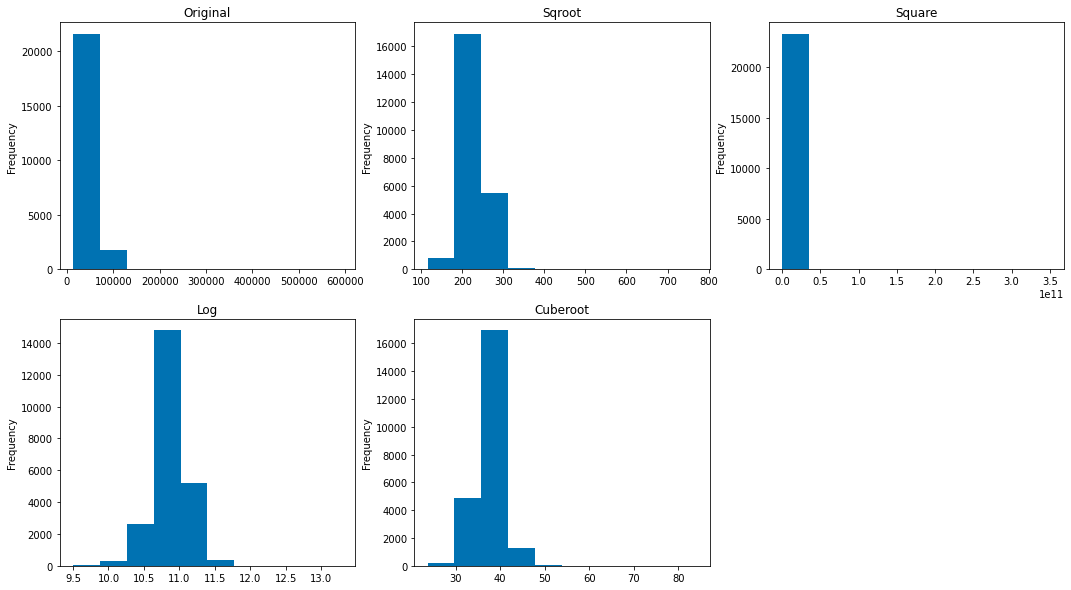

In [61]:
transformation(dummy,'Disbursed_Amount')

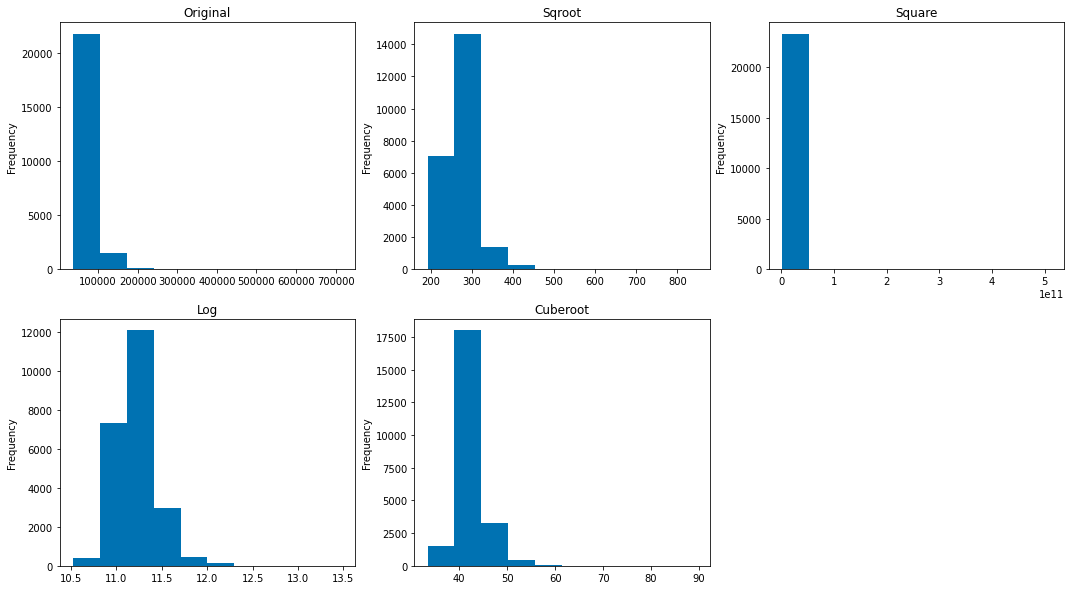

In [28]:
transformation(dummy,'Asset_Cost')

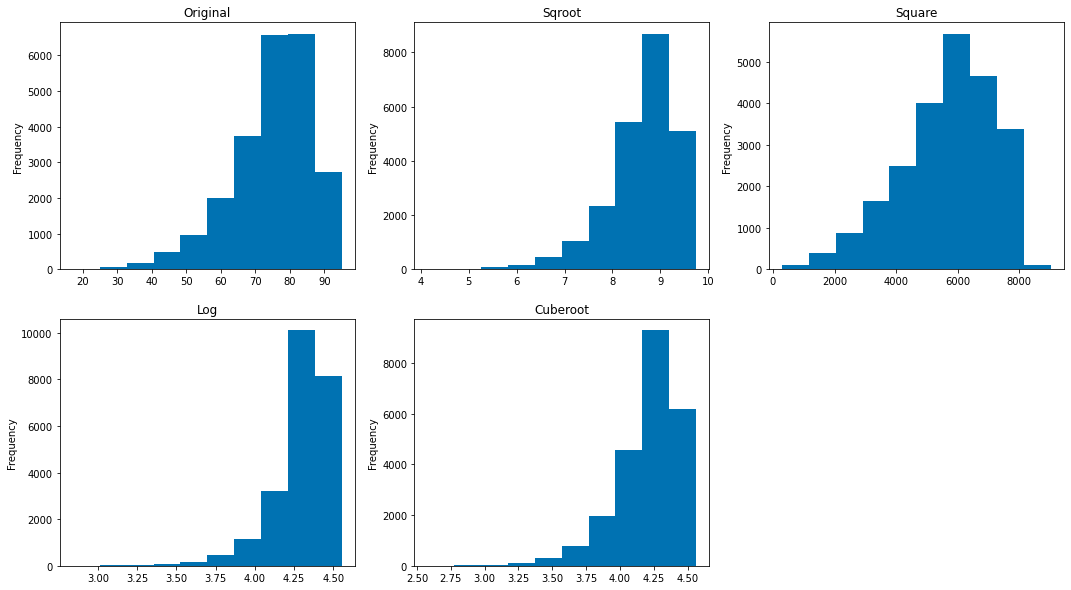

In [29]:
transformation(dummy,'ltv')

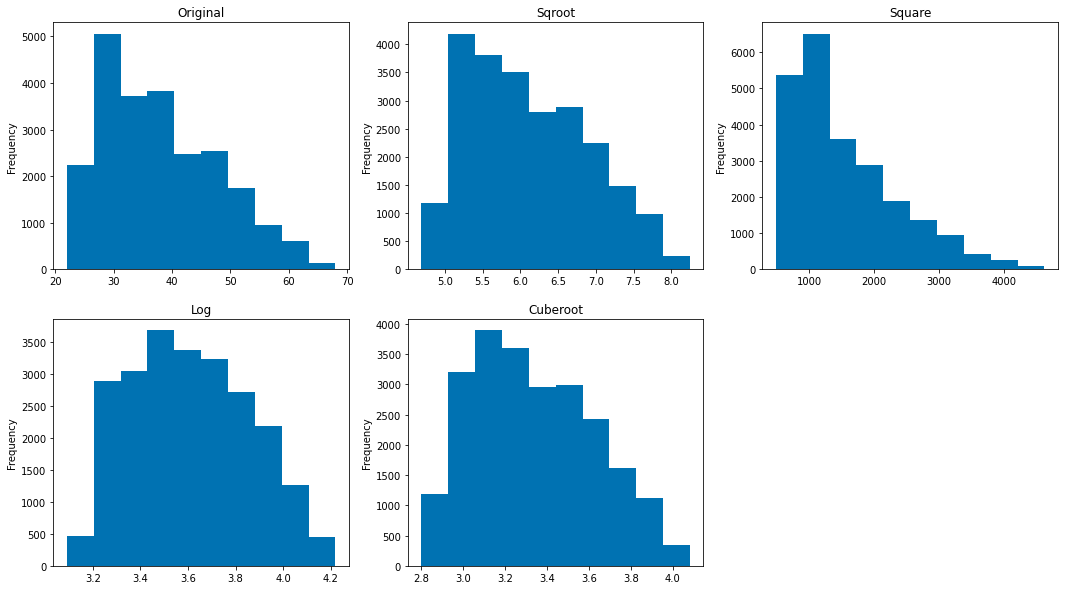

In [34]:
transformation(dummy,'Age')

In [21]:
df.columns

Index(['Disbursed_Amount', 'Asset_Cost', 'ltv', 'Employment_Type',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'PERFORM_CNS.SCORE', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Loan_Default', 'State_Name', 'Region_Name', 'Age',
       'Credit_Hist_Length_in_Months'],
      dtype='object')

In [ ]:
# Disbursed_Amount = log
# Asset_Cost = log
# ltv = Square
# Age = log

In [20]:
df['Disbursed_Amount']=np.log(df['Disbursed_Amount'])
df['Asset_Cost']=np.log(df['Asset_Cost'])
df['ltv']=(df['ltv'])**2
df['Age']=np.log(df['Age'])

In [21]:
df.head()

,Disbursed_Amount,Asset_Cost,ltv,Employment_Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,State_Name,Region_Name,Age,Credit_Hist_Length_in_Months
Loan_Id,,,,,,,,,,,,,,,,
1,10.503395,11.095135,3157.3161,Self employed,Yes,No,No,No,0,0,0,0,Maharashtra,West,3.465736,0
2,10.794440,11.146243,5205.6225,Salaried,Yes,No,No,No,783,0,0,0,Tamil Nadu,South,3.433987,30
3,10.921396,11.102548,7225.0000,Self employed,Yes,No,No,No,0,0,0,1,Bihar,East,3.367296,0
4,10.796489,11.068714,6077.7616,Self employed,Yes,No,No,No,0,0,0,0,Rajasthan,North,3.496508,0
5,10.606437,10.991814,5001.3184,Self employed,Yes,No,No,No,14,1,1,0,Tamil Nadu,South,3.871201,37


In [22]:
df=pd.get_dummies(df,drop_first=True)
df.head()

,Disbursed_Amount,Asset_Cost,ltv,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,Age,Credit_Hist_Length_in_Months,Employment_Type_Self employed,...,State_Name_Rajasthan,State_Name_Sikkim,State_Name_Tamil Nadu,State_Name_Telangana,State_Name_Uttar Pradesh,State_Name_Uttarakhand,State_Name_West Bengal,Region_Name_North,Region_Name_South,Region_Name_West
Loan_Id,,,,,,,,,,,,,,,,,,,,,
1,10.503395,11.095135,3157.3161,0,0,0,0,3.465736,0,1,...,0,0,0,0,0,0,0,0,0,1
2,10.794440,11.146243,5205.6225,783,0,0,0,3.433987,30,0,...,0,0,1,0,0,0,0,0,1,0
3,10.921396,11.102548,7225.0000,0,0,0,1,3.367296,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10.796489,11.068714,6077.7616,0,0,0,0,3.496508,0,1,...,1,0,0,0,0,0,0,1,0,0
5,10.606437,10.991814,5001.3184,14,1,1,0,3.871201,37,1,...,0,0,1,0,0,0,0,0,1,0


In [23]:
X=df.drop('Loan_Default',axis=1)
y=df['Loan_Default']

In [24]:
std_scale= StandardScaler()
col=['Disbursed_Amount','Asset_Cost','ltv','PERFORM_CNS.SCORE','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','Age','Credit_Hist_Length_in_Months']
for i in col:
    X[i]= std_scale.fit_transform(X[i].values.reshape(-1,1))

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=42,stratify=y)
print('x_train :',x_train.shape)
print('x_test  :',x_test.shape)
print('y_train :',y_train.shape)
print('y_test  :',y_test.shape)

x_train : (15154, 34)
x_test  : (8161, 34)
y_train : (15154,)
y_test  : (8161,)


## Over sampling after split

In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=3,k_neighbors=3)
oversampled_X, oversampled_Y = sm.fit_resample(x_train,y_train)
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [58]:
print(oversampled_X.shape)
print(oversampled_Y.shape)

(25464, 34)
(25464,)


### Function for model building

In [27]:
def model_result(classifier,grid,cv):
    print('****')
    print(classifier)
    print('****')
    model=classifier
    model.fit(oversampled_X, oversampled_Y)
    y_predict=model.predict(x_test)
    y_pred_train=model.predict(oversampled_X)
    print(classification_report(y_test,y_predict))
    print(classification_report(y_train,y_pred_train))
    sns.set(rc={'figure.figsize':(3.5,3.5)})
    plot_confusion_matrix(model,x_test,y_test)
    plt.axis('off')
    plt.show()
    rscv=RandomizedSearchCV(model,grid,n_iter=12,cv=cv,random_state=3,scoring='roc_auc')
    rscv.fit(oversampled_X, oversampled_Y)
    print('Best Parameters',rscv.best_params_)
    print('Best Score = ', round(rscv.best_score_,2))

## KNeighbors Classifier

****
KNeighborsClassifier()
****
              precision    recall  f1-score   support

           0       0.79      0.57      0.66      6367
           1       0.23      0.47      0.31      1794

    accuracy                           0.55      8161
   macro avg       0.51      0.52      0.49      8161
weighted avg       0.67      0.55      0.59      8161



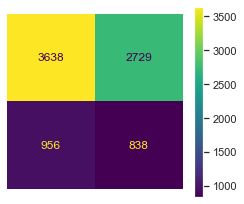

Best Parameters {'weights': 'distance', 'n_neighbors': 6, 'leaf_size': 21}
Best Score =  nan


In [28]:
grid={'n_neighbors':range(2,10),'weights':['uniform', 'distance'],'leaf_size':range(1,30)}
cv=KFold(n_splits=5,shuffle=False)

model_result(KNeighborsClassifier(),grid,cv)

## DecisionTree Classifier

****
DecisionTreeClassifier(class_weight='balanced')
****
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      6367
           1       0.24      0.36      0.29      1794

    accuracy                           0.61      8161
   macro avg       0.51      0.52      0.51      8161
weighted avg       0.67      0.61      0.63      8161



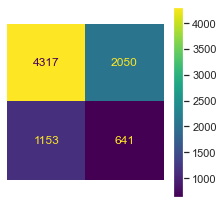

Best Parameters {'min_samples_leaf': 30, 'max_leaf_nodes': 22, 'max_depth': 33}
Best Score =  nan


In [55]:
grid={'max_depth':[i for i in range(1,50)],'max_leaf_nodes':[i for i in range(1,50)],'min_samples_leaf':[i for i in range(5,50)]}
cv=KFold(n_splits=5,shuffle=False)

model_result(DecisionTreeClassifier(class_weight='balanced'),grid,cv)

## RandomForest Classifier

****
RandomForestClassifier(class_weight='balanced', oob_score=True)
****
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      6367
           1       0.26      0.22      0.24      1794

    accuracy                           0.69      8161
   macro avg       0.53      0.52      0.52      8161
weighted avg       0.67      0.69      0.68      8161



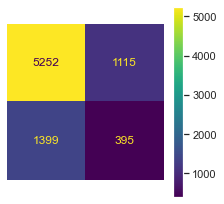

Best Parameters {'n_estimators': 134, 'max_depth': 22}
Best Score =  nan


In [56]:
grid={'n_estimators':range(20,300),'max_depth':[i for i in range(1,50)]}
cv=KFold(n_splits=5,shuffle=False)

model_result(RandomForestClassifier(oob_score=True,class_weight='balanced'),grid,cv)

## AdaBoost Classifier

****
AdaBoostClassifier()
****
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      6367
           1       0.26      0.53      0.35      1794

    accuracy                           0.57      8161
   macro avg       0.54      0.56      0.52      8161
weighted avg       0.69      0.57      0.61      8161



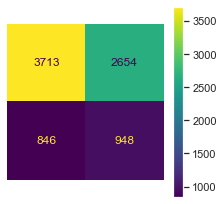

Best Parameters {'n_estimators': 173, 'learning_rate': 1.5}
Best Score =  nan


In [57]:
grid={'n_estimators':range(20,300),'learning_rate':[1.1,1.2,1.3,1.4,1.5]}
cv=KFold(n_splits=5,shuffle=False)

model_result(AdaBoostClassifier(),grid,cv)

## GradientBoosting Classifier

****
GradientBoostingClassifier()
****
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      6367
           1       0.27      0.41      0.33      1794

    accuracy                           0.63      8161
   macro avg       0.54      0.55      0.54      8161
weighted avg       0.69      0.63      0.65      8161



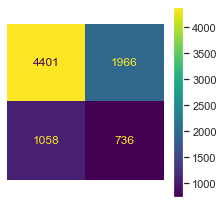

Best Parameters {'n_estimators': 238, 'loss': 'deviance', 'learning_rate': 0.4}
Best Score =  nan


In [58]:
grid={'n_estimators':range(20,300),'learning_rate':[0.1,0.2,0.3,0.4,0.5],'loss':['deviance', 'exponential']}
cv=KFold(n_splits=5,shuffle=False)

model_result(GradientBoostingClassifier(),grid,cv)

## XGB Classifier

****
XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
****
[19:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

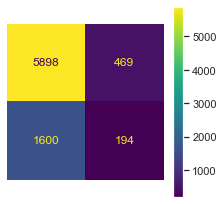

[19:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:50:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [77]:
grid={'n_estimators':range(20,300)}
cv=KFold(n_splits=5,shuffle=False)

model_result(xgb.XGBClassifier(booster='gbtree'),grid,cv)

### Comments:
1. When we do over sampling after split, the precision and accuracy of predicting True Positive becomes close to 20 %.
2. After performing downsampling, upsampling with different parameters, i was still getting low precision and recall.
3. Even after trial and error the precision was low.
4. After hyper parameter tuning, the accuracy was showing nan. So no effect of tuning also.
5. The classifier is only predicting True Negative well. But here our target is predicitng True Positive.
6. Performing oversampling before split may cause the information leak from train data to test data.
7. To overcome this, stratifying the data while splitting but still there is chance of training data ending up in test set.
8. To solve this problem, i will check how the model works on original data.

1

## Oversampling before split

In [60]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=3,k_neighbors=3)
oversampled_X, oversampled_Y = sm.fit_resample(X,y)
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [61]:
x_train,x_test,y_train,y_test=train_test_split(oversampled_X, oversampled_Y,test_size=0.25,random_state=42,stratify=oversampled_Y)
print('x_train :',x_train.shape)
print('x_test  :',x_test.shape)
print('y_train :',y_train.shape)
print('y_test  :',y_test.shape)

x_train : (27283, 34)
x_test  : (9095, 34)
y_train : (27283,)
y_test  : (9095,)


In [62]:
def Model_result(classifier,grid,cv):
    print('****')
    print(classifier)
    print('****')
    model=classifier
    model.fit(x_train,y_train)
    y_predict=model.predict(x_test)
    y_pred_train=model.predict(x_train)
    print(classification_report(y_test,y_predict))
    print(classification_report(y_train,y_pred_train))
    sns.set(rc={'figure.figsize':(3.5,3.5)})
    plot_confusion_matrix(model,x_test,y_test)
    plt.axis('off')
    plt.show()
    rscv=RandomizedSearchCV(model,grid,n_iter=12,cv=cv,random_state=3,scoring='roc_auc')
    rscv.fit(x_train,y_train)
    print('Best Parameters',rscv.best_params_)
    print('Best Score = ', round(rscv.best_score_,2))

## KNeighbors Classifier

****
KNeighborsClassifier()
****
              precision    recall  f1-score   support

           0       0.81      0.57      0.67      4548
           1       0.67      0.87      0.76      4547

    accuracy                           0.72      9095
   macro avg       0.74      0.72      0.71      9095
weighted avg       0.74      0.72      0.71      9095



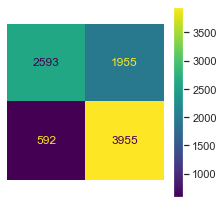

Best Parameters {'weights': 'distance', 'n_neighbors': 6, 'metric': 'minkowski', 'leaf_size': 2}
Best Score =  0.84


In [63]:
grid={'n_neighbors':range(2,7),'metric':['minkowski'],'weights':['uniform', 'distance'],'leaf_size':range(2,25,3)}
cv=KFold(n_splits=5,shuffle=False)

Model_result(KNeighborsClassifier(),grid,cv)

## DecisionTree Classifier

****
DecisionTreeClassifier()
****
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      4548
           1       0.68      0.71      0.70      4547

    accuracy                           0.69      9095
   macro avg       0.69      0.69      0.69      9095
weighted avg       0.69      0.69      0.69      9095



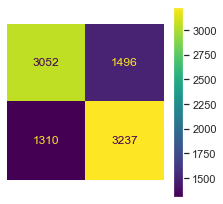

Best Parameters {'min_samples_leaf': 14, 'max_leaf_nodes': 47, 'max_depth': 35}
Best Score =  0.67


In [82]:
grid={'max_depth':[i for i in range(1,50)],'max_leaf_nodes':[i for i in range(1,50)],'min_samples_leaf':[i for i in range(5,50)]}
cv=KFold(n_splits=5,shuffle=False)

Model_result(DecisionTreeClassifier(),grid,cv)

## RandomForest Classifier

****
RandomForestClassifier(class_weight='balanced', oob_score=True, warm_start=True)
****
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4548
           1       0.80      0.82      0.81      4547

    accuracy                           0.81      9095
   macro avg       0.81      0.81      0.81      9095
weighted avg       0.81      0.81      0.81      9095



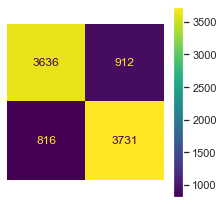

Best Parameters {'n_estimators': 215, 'max_depth': 40}
Best Score =  0.88


In [83]:
grid={'n_estimators':range(20,300),'max_depth':[i for i in range(1,50)]}
cv=KFold(n_splits=5,shuffle=False)

Model_result(RandomForestClassifier(oob_score=True,warm_start=True,class_weight='balanced'),grid,cv)

## AdaBoost Classifier

****
AdaBoostClassifier()
****
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      4548
           1       0.62      0.68      0.65      4547

    accuracy                           0.63      9095
   macro avg       0.63      0.63      0.63      9095
weighted avg       0.63      0.63      0.63      9095



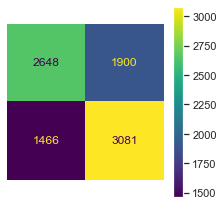

Best Parameters {'n_estimators': 249, 'learning_rate': 1.3}
Best Score =  0.79


In [84]:
grid={'n_estimators':range(20,300),'learning_rate':[1.1,1.2,1.3,1.4,1.5]}
cv=KFold(n_splits=5,shuffle=False)

Model_result(AdaBoostClassifier(),grid,cv)

## GradientBoosting Classifier

****
GradientBoostingClassifier()
****
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      4548
           1       0.72      0.70      0.71      4547

    accuracy                           0.71      9095
   macro avg       0.71      0.71      0.71      9095
weighted avg       0.71      0.71      0.71      9095



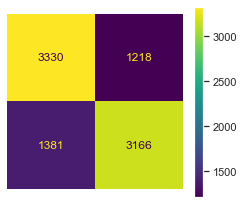

Best Parameters {'n_estimators': 287, 'loss': 'exponential', 'learning_rate': 0.3}
Best Score =  0.87


In [279]:
grid={'n_estimators':range(20,300),'learning_rate':[0.1,0.2,0.3,0.4,0.5],'loss':['deviance', 'exponential']}
cv=KFold(n_splits=5,shuffle=False)

Model_result(GradientBoostingClassifier(),grid,cv)

## XGB Classifier

****
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
****
[21:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beha

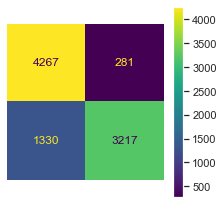

[21:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

KeyboardInterrupt: 

In [64]:
grid={'n_estimators':range(20,300)}
cv=KFold(n_splits=5,shuffle=False)

Model_result(xgb.XGBClassifier(),grid,cv)

## data for model:
1. Which are Sensitive to outliers.

In [15]:
def outliers_limits(col):
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    UL=Q3+(1.5*IQR)
    LL=Q1-(1.5*IQR)
    return UL,LL

In [16]:
outliers_columns=['Disbursed_Amount','Asset_Cost','ltv','Credit_Hist_Length_in_Months']

In [17]:
for column in outliers_columns:
    UL,LL=outliers_limits(data_out[column])
    data_out[column]=np.where(data_out[column]>UL,UL , np.where(data_out[column]<LL,LL,data_out[column]))

In [18]:
data_out.head()

,Disbursed_Amount,Asset_Cost,ltv,Employment_Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,State_Name,Region_Name,Age,Credit_Hist_Length_in_Months
Loan_Id,,,,,,,,,,,,,,,,
1,36439.0,65850.0,56.19,Self employed,Yes,No,No,No,0,0,0,0,Maharashtra,West,32,0.0
2,48749.0,69303.0,72.15,Salaried,Yes,No,No,No,783,0,0,0,Tamil Nadu,South,31,30.0
3,55348.0,66340.0,85.00,Self employed,Yes,No,No,No,0,0,0,1,Bihar,East,29,0.0
4,48849.0,64133.0,77.96,Self employed,Yes,No,No,No,0,0,0,0,Rajasthan,North,33,0.0
5,40394.0,59386.0,70.72,Self employed,Yes,No,No,No,14,1,1,0,Tamil Nadu,South,48,37.0


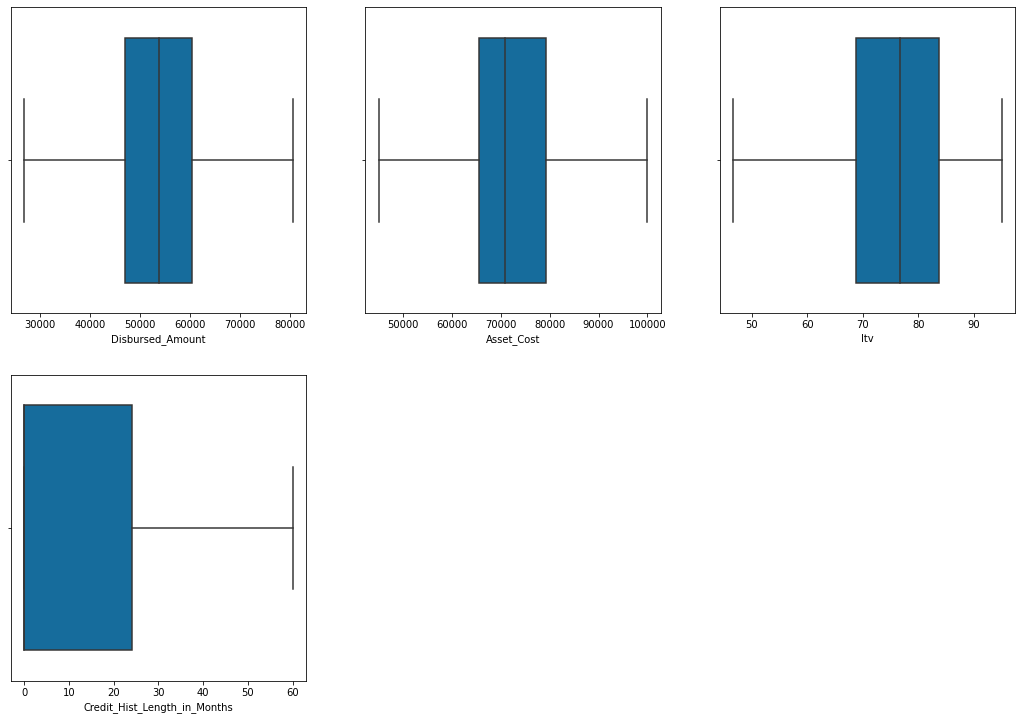

In [21]:
# Plotting boxplot to check whether outliers are treated or not.
plt.figure(figsize=(18,80),facecolor='white')
plot_num=1
for i in outliers_columns:
    ax=plt.subplot(12,3,plot_num)
    sns.boxplot(data_out[i])
    plt.xlabel(i)
    plot_num+=1
plt.show()

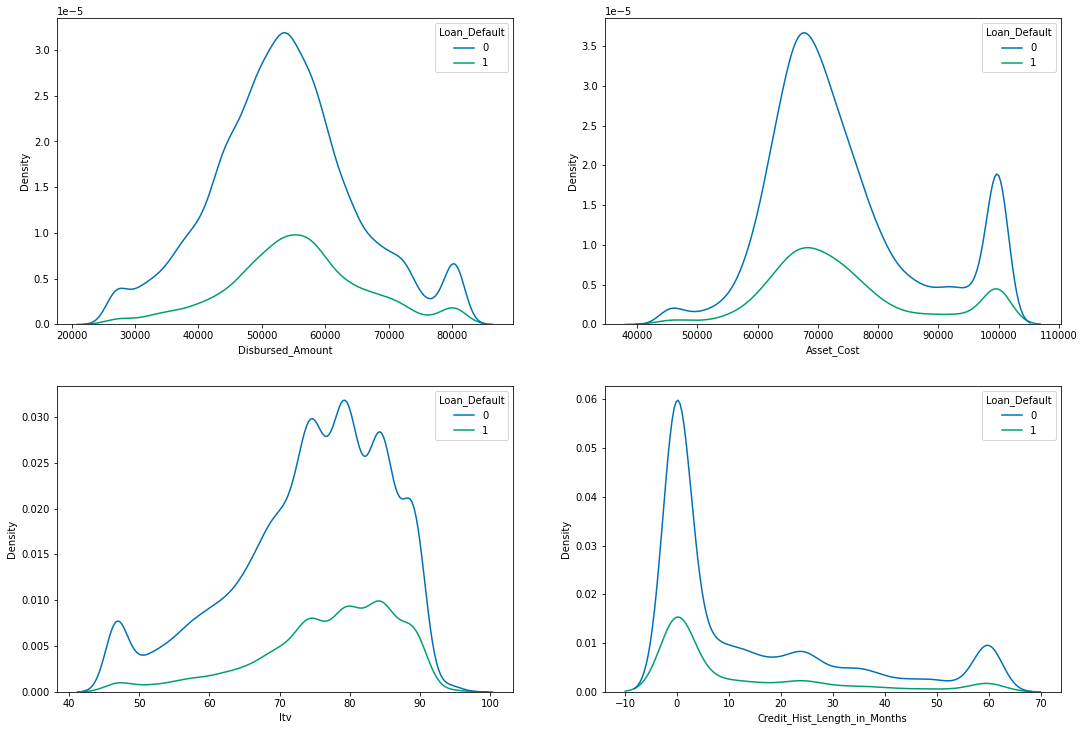

In [22]:
# Plotting distplot to visualize distribution after outlier treatment
plt.figure(figsize=(18,80),facecolor='white')
plot_num=1
for i in outliers_columns:
    ax=plt.subplot(12,2,plot_num)
    sns.kdeplot(x=i,data=data_out,hue='Loan_Default')
    plot_num+=1
plt.show()

In [23]:
dfo=pd.get_dummies(data_out,drop_first=True)
dfo.head()

,Disbursed_Amount,Asset_Cost,ltv,PERFORM_CNS.SCORE,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Loan_Default,Age,Credit_Hist_Length_in_Months,Employment_Type_Self employed,...,State_Name_Rajasthan,State_Name_Sikkim,State_Name_Tamil Nadu,State_Name_Telangana,State_Name_Uttar Pradesh,State_Name_Uttarakhand,State_Name_West Bengal,Region_Name_North,Region_Name_South,Region_Name_West
Loan_Id,,,,,,,,,,,,,,,,,,,,,
1,36439.0,65850.0,56.19,0,0,0,0,32,0.0,1,...,0,0,0,0,0,0,0,0,0,1
2,48749.0,69303.0,72.15,783,0,0,0,31,30.0,0,...,0,0,1,0,0,0,0,0,1,0
3,55348.0,66340.0,85.00,0,0,0,1,29,0.0,1,...,0,0,0,0,0,0,0,0,0,0
4,48849.0,64133.0,77.96,0,0,0,0,33,0.0,1,...,1,0,0,0,0,0,0,1,0,0
5,40394.0,59386.0,70.72,14,1,1,0,48,37.0,1,...,0,0,1,0,0,0,0,0,1,0


In [24]:
X=dfo.drop('Loan_Default',axis=1)
y=dfo['Loan_Default']

In [25]:
std_scaler=StandardScaler()

In [26]:
std_col=['Disbursed_Amount','Asset_Cost','ltv','PERFORM_CNS.SCORE','Age','Credit_Hist_Length_in_Months','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES']

In [27]:
for i in std_col:
    X[i]= std_scaler.fit_transform(X[i].values.reshape(-1,1))

In [28]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)
print('x_train :',x_train.shape)
print('x_test  :',x_test.shape)
print('y_train :',y_train.shape)
print('y_test  :',y_test.shape)

x_train : (17486, 34)
x_test  : (5829, 34)
y_train : (17486,)
y_test  : (5829,)


In [29]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=42,k_neighbors=3)
oversampled_X, oversampled_Y = sm.fit_resample(x_train,y_train)
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

## Logistic Regression

In [33]:
log_model= LogisticRegression(class_weight='balanced')
log_model.fit(oversampled_X, oversampled_Y)
y_predict=log_model.predict(x_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.66      0.72      4547
           1       0.27      0.45      0.34      1282

    accuracy                           0.61      5829
   macro avg       0.54      0.55      0.53      5829
weighted avg       0.69      0.61      0.64      5829



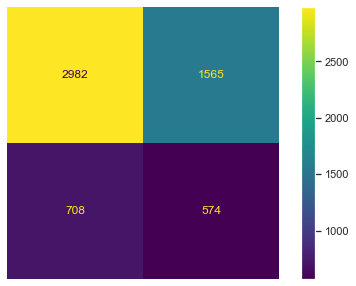

In [34]:
sns.set(rc={'figure.figsize':(8,5)})
plot_confusion_matrix(log_model,x_test,y_test)
plt.axis('off')
plt.show()

In [41]:
grid={'max_iter':range(10,300),'C':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3]}
cv=KFold(n_splits=5,shuffle=False)
rscv=RandomizedSearchCV(log_model,grid,n_iter=12,cv=cv,random_state=3,scoring='roc_auc')
rscv.fit(oversampled_X, oversampled_Y)
print('Best Parameters',rscv.best_params_)
print('Best Score = ', round(rscv.best_score_,2))

Best Parameters {'max_iter': 168, 'C': 1.1}
Best Score =  nan


# Comments:
1. RandomForestClassifier and GradientboostClassifier gives high accuracy and precision while predicting True Positive.
2. XGBoostClassifier gives 92% precision while prediciting True Positive.
3. RandomForestClassifier with hyper parameter tuning gives 88% accuracy.
4. RandomForestClassifier is not sensitive to outliers and also is is best for unbalanced data.
5. For this dataset, i think RandomForestClassifier is best.